In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import scipy

In [2]:
os.getcwd()

'c:\\Users\\Kanishka\\OneDrive\\Desktop\\AI_DermalScan'

In [2]:
dataset = './Dataset'
outputs_path = './Outputs'
def class_distribution(dataset):
    class_num = 1
    labels = []
    counts = []
    for classes in os.listdir(dataset):
        class_path = os.path.join(dataset, classes)
        labels.append(classes)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            counts.append(num_images)
            print(f'Class {class_num}')
            print(f'Class: {classes}')
            print(f'Number of images: {num_images}')
            print('-----------------------')
            class_num += 1
    return labels, counts
labels, counts = class_distribution(dataset)
        

Class 1
Class: clear skin
Number of images: 300
-----------------------
Class 2
Class: dark spots
Number of images: 300
-----------------------
Class 3
Class: puffy eyes
Number of images: 300
-----------------------
Class 4
Class: wrinkles
Number of images: 300
-----------------------


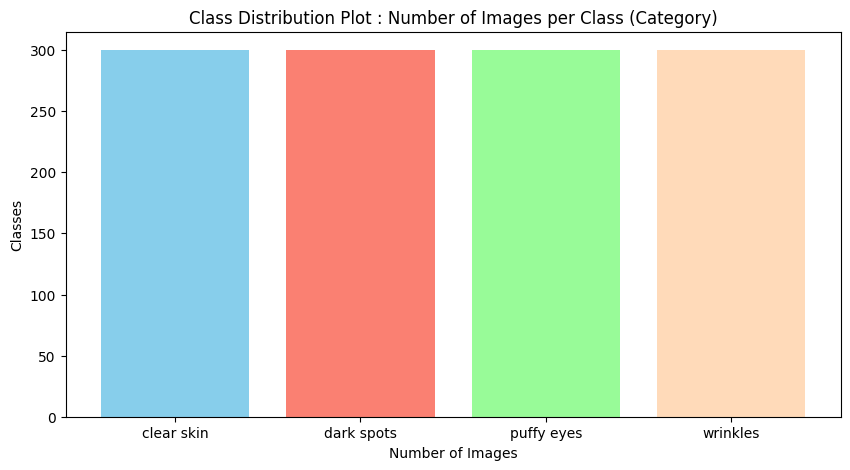

In [3]:
def plot_class_distribution(labels, counts):
    plt.figure(figsize=(10,5))
    plt.bar(labels, counts,color=('skyblue','salmon','palegreen','peachpuff'))
    plt.title('Class Distribution Plot : Number of Images per Class (Category)')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.savefig('Class_Distribution_Plot.png')
    plt.show()
plot_class_distribution(labels, counts)

In [4]:
#This function plots the augmentation scattering per batch

def plot_augmentation_scattering(generator, title="Augmentation Scattering Per Batch"):

    images, labels = next(generator)

    class_indices = np.argmax(labels, axis=1) #to get the class indices from one-hot encoded labels

    # count how many images per class appear in the batch
    unique_classes, counts = np.unique(class_indices, return_counts=True)

    # class names
    class_labels = list(generator.class_indices.keys())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, counts)
    plt.xlabel("Classes")
    plt.ylabel("Images in this batch")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

    return unique_classes, counts

In [5]:
#In this cell a generator object is created for training and validation data augmentation. The rules for augmentation are defined within the ImageDataGenerator function.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)


valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [6]:
#In this cell, the augmentation generator is applied to actual image data from the dataset directory. The images are resized to 224x224 pixels, and the batch size is set to 32. Training and validation subsets are created based on the defined split.(80-20)

img_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  #One-hot encoding
    shuffle=True,
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)



Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


One-hot encoded labels:
 [[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


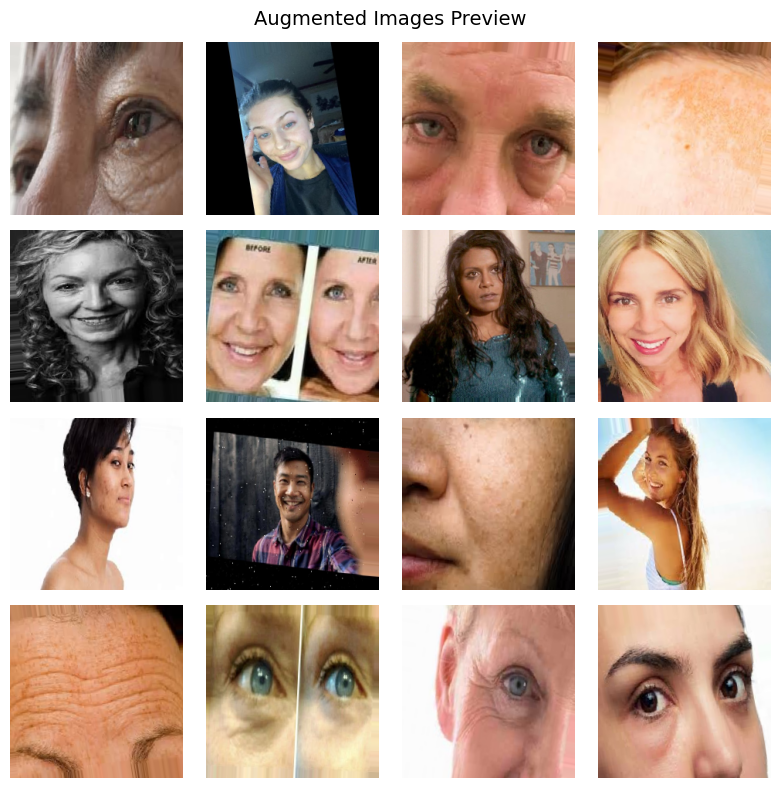

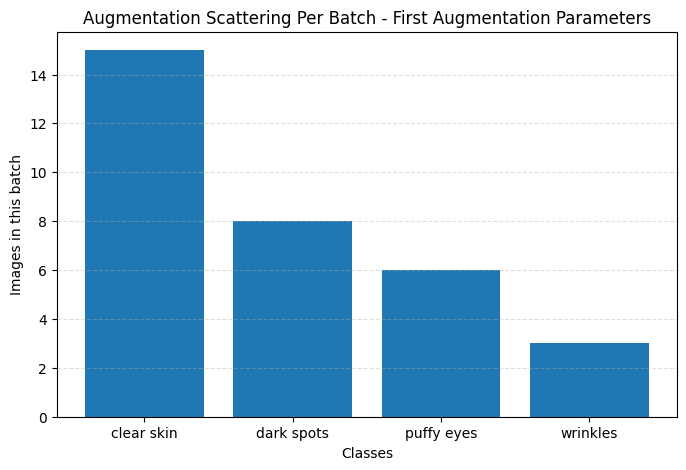

(array([0, 1, 2, 3], dtype=int64), array([15,  8,  6,  3], dtype=int64))

In [7]:
#See augmented images using the First augmentation parameters
# Take one batch from train generator
images, labels = next(train_generator)
print("One-hot encoded labels:\n", labels)


plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Augmented Images Preview", fontsize=14)
plt.tight_layout()

# Save the figure
count = len(os.listdir('Outputs'))
filename = f'Outputs/Augmented_Images_{count+1}.png'
plt.savefig(filename)

plt.show()

plot_augmentation_scattering(train_generator, title="Augmentation Scattering Per Batch - First Augmentation Parameters")

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(base_model, num_classes, lr=1e-4, dropout_rate=0.4):

    # Freeze base model
    base_model.trainable = False

    # Custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Load pretrained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Build model
model = build_model(
    base_model=base_model,
    num_classes=train_generator.num_classes,
    lr=1e-5,
    dropout_rate=0.4
)

# Callbacks for Phase 1
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True
    ),
    ModelCheckpoint(
    filepath="MobileNetV2_bestmodel.h5",  
    monitor="val_accuracy",           
    save_best_only=True,              
    save_weights_only=False,          
    verbose=1
)
]

# Train (Feature Extraction)
history_phase1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=callbacks_phase1
)


Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 2.0580 - accuracy: 0.2510
Epoch 1: val_accuracy improved from -inf to 0.25833, saving model to MobileNetV2_bestmodel.h5


c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 19s 514ms/step - loss: 2.0580 - accuracy: 0.2510 - val_loss: 1.6886 - val_accuracy: 0.2583
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 1.9889 - accuracy: 0.2396
Epoch 2: val_accuracy improved from 0.25833 to 0.27917, saving model to MobileNetV2_bestmodel.h5
30/30 [==============================] - 14s 476ms/step - loss: 1.9889 - accuracy: 0.2396 - val_loss: 1.6344 - val_accuracy: 0.2792
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 1.9442 - accuracy: 0.2500
Epoch 3: val_accuracy improved from 0.27917 to 0.29167, saving model to MobileNetV2_bestmodel.h5
30/30 [==============================] - 14s 481ms/step - loss: 1.9442 - accuracy: 0.2500 - val_loss: 1.5872 - val_accuracy: 0.2917
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 1.9420 - accuracy: 0.2458
Epoch 4: val_accuracy improved from 0.29167 to 0.29583, saving model to MobileNetV2_bestmodel.h5
30/30 [========================

In [29]:
print("Training Phase 1 Results:\n")
best_val_acc = max(history_phase1.history['val_accuracy'])
best_epoch = history_phase1.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_phase1.history['accuracy'])
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")


Training Phase 1 Results:

Best Validation Accuracy: 0.6625
Best Epoch: 50
Best Training Accuracy: 0.5271


In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


base_model.trainable = False

for layer in base_model.layers[:-50]:
    layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=5e-6), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_finetune = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6
    ),

    ModelCheckpoint(
    filepath="MobileNetV2_bestmodel2.h5",  
    monitor="val_accuracy",           
    save_best_only=True,              
    save_weights_only=False,          
    verbose=1
)
]

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=18,
    callbacks=callbacks_finetune
)


Epoch 1/18
30/30 [==============================] - ETA: 0s - loss: 1.5914 - accuracy: 0.3656
Epoch 1: val_accuracy improved from -inf to 0.67917, saving model to MobileNetV2_bestmodel2.h5


c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 36s 837ms/step - loss: 1.5914 - accuracy: 0.3656 - val_loss: 0.8566 - val_accuracy: 0.6792 - lr: 5.0000e-06
Epoch 2/18
30/30 [==============================] - ETA: 0s - loss: 1.5407 - accuracy: 0.4104
Epoch 2: val_accuracy did not improve from 0.67917
30/30 [==============================] - 23s 765ms/step - loss: 1.5407 - accuracy: 0.4104 - val_loss: 0.8498 - val_accuracy: 0.6792 - lr: 5.0000e-06
Epoch 3/18
30/30 [==============================] - ETA: 0s - loss: 1.4345 - accuracy: 0.4437
Epoch 3: val_accuracy did not improve from 0.67917
30/30 [==============================] - 23s 768ms/step - loss: 1.4345 - accuracy: 0.4437 - val_loss: 0.8430 - val_accuracy: 0.6792 - lr: 5.0000e-06
Epoch 4/18
30/30 [==============================] - ETA: 0s - loss: 1.4341 - accuracy: 0.4229
Epoch 4: val_accuracy did not improve from 0.67917
30/30 [==============================] - 23s 770ms/step - loss: 1.4341 - accuracy: 0.4229 - val_loss: 0.8379 - val_acc

In [31]:


base_model.trainable = False

for layer in base_model.layers[:-80]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-6),  
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_finetune1 = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "MobileNetV2_finetuned_bestmodel3.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_finetune1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,          
    callbacks=callbacks_finetune1
)


Epoch 1/10
30/30 [==============================] - 34s 817ms/step - loss: 1.5164 - accuracy: 0.4156 - val_loss: 0.8554 - val_accuracy: 0.6833 - lr: 1.0000e-06
Epoch 2/10
30/30 [==============================] - 24s 792ms/step - loss: 1.5245 - accuracy: 0.3865 - val_loss: 0.8547 - val_accuracy: 0.6750 - lr: 1.0000e-06
Epoch 3/10
30/30 [==============================] - 38s 1s/step - loss: 1.5091 - accuracy: 0.4010 - val_loss: 0.8548 - val_accuracy: 0.6792 - lr: 1.0000e-06
Epoch 4/10
30/30 [==============================] - 45s 1s/step - loss: 1.4869 - accuracy: 0.4021 - val_loss: 0.8555 - val_accuracy: 0.6792 - lr: 1.0000e-06
Epoch 5/10
30/30 [==============================] - 50s 2s/step - loss: 1.5133 - accuracy: 0.4115 - val_loss: 0.8573 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 6/10
30/30 [==============================] - 42s 1s/step - loss: 1.4550 - accuracy: 0.4187 - val_loss: 0.8593 - val_accuracy: 0.6833 - lr: 1.0000e-06
Epoch 7/10
30/30 [==============================] - 

In [32]:
print("First Fine-tuning Results:\n")
best_val_acc = max(history_finetune.history['val_accuracy'])
best_epoch = history_finetune.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_finetune.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")

print("\nSecond Fine-tuning Results:\n")
best_val_acc = max(history_finetune1.history['val_accuracy'])
best_epoch = history_finetune1.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_finetune1.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")

First Fine-tuning Results:

Best Validation Accuracy: 0.6792
Best Epoch: 1
Best Training Accuracy: 0.4437

Second Fine-tuning Results:

Best Validation Accuracy: 0.6875
Best Epoch: 5
Best Training Accuracy: 0.4187


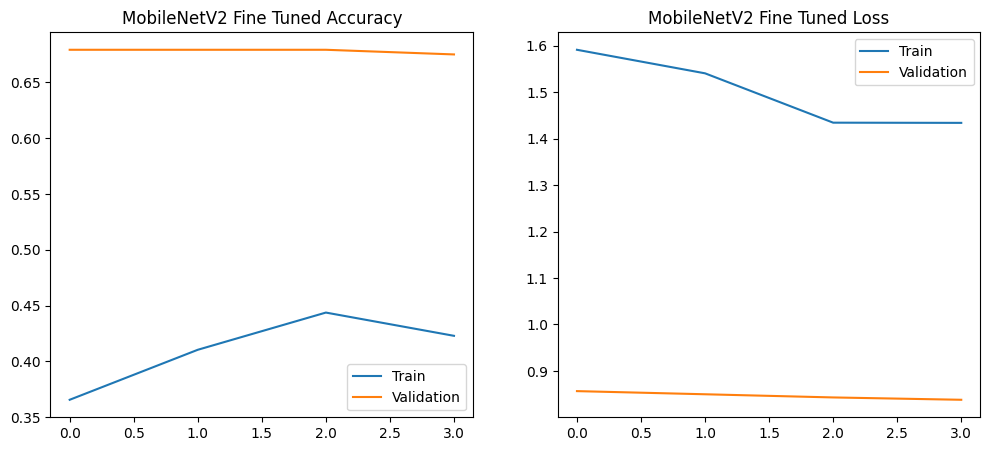

MobileNetV2: 0.6791666746139526
MobileNetV2: 0.4437499940395355


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

plot_history(history_finetune, "MobileNetV2 Fine Tuned")

print("MobileNetV2:", max(history_finetune.history['val_accuracy']))
print('MobileNetV2:', max(history_finetune.history['accuracy']))




In [20]:
from tensorflow.keras.models import load_model

model = load_model('MobileNetV2_finetuned.h5')
val_acc = max(history_finetune.history['val_accuracy'])
print("Last recorded best val acc:", val_acc)
loss, acc = model.evaluate(valid_generator)
print("Validation Accuracy (reloaded model):", acc)


Last recorded best val acc: 0.6458333134651184
8/8 [==============================] - 3s 161ms/step - loss: 0.4460 - accuracy: 0.8458
Validation Accuracy (reloaded model): 0.8458333611488342


In [21]:
model.save("MobileNetV2_High_accuracy.h5")


c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [19]:
def build_resnet_model(num_classes):
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False  # Freeze initially

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [20]:
resnet_model = build_resnet_model(train_generator.num_classes)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_resnet = [
    EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-6),
    ModelCheckpoint("ResNet50_best.h5", monitor="val_accuracy", save_best_only=True)
]

history_resnet = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks_resnet
)

best_val_acc_resnet = max(history_resnet.history["val_accuracy"])
print("Best Validation Accuracy (ResNet50):", best_val_acc_resnet)

Epoch 1/15
30/30 [==============================] - 56s 2s/step - loss: 1.7069 - accuracy: 0.2573 - val_loss: 1.3872 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/15
30/30 [==============================] - 30s 1s/step - loss: 1.5921 - accuracy: 0.2573 - val_loss: 1.3583 - val_accuracy: 0.4292 - lr: 1.0000e-04
Epoch 3/15
30/30 [==============================] - 29s 956ms/step - loss: 1.5574 - accuracy: 0.2688 - val_loss: 1.3594 - val_accuracy: 0.2708 - lr: 1.0000e-04
Epoch 4/15
30/30 [==============================] - 29s 949ms/step - loss: 1.5634 - accuracy: 0.2667 - val_loss: 1.3341 - val_accuracy: 0.4042 - lr: 1.0000e-04
Epoch 5/15
30/30 [==============================] - 80s 3s/step - loss: 1.4927 - accuracy: 0.2740 - val_loss: 1.3160 - val_accuracy: 0.4917 - lr: 1.0000e-04
Epoch 6/15
30/30 [==============================] - 68s 2s/step - loss: 1.4903 - accuracy: 0.2677 - val_loss: 1.3075 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 7/15
30/30 [==============================] - 

In [21]:
for layer in resnet_model.layers:
    layer.trainable = False

for layer in resnet_model.layers[-80:]:
    layer.trainable = True

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_resnet_finetune = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks_resnet
)

best_resnet_val = max(history_resnet_finetune.history["val_accuracy"])
print("Best ResNet50 Validation Accuracy:", best_resnet_val)


Epoch 1/30
30/30 [==============================] - 62s 2s/step - loss: 2.4344 - accuracy: 0.2979 - val_loss: 1.3089 - val_accuracy: 0.3667 - lr: 1.0000e-05
Epoch 2/30
30/30 [==============================] - 43s 1s/step - loss: 1.1688 - accuracy: 0.4948 - val_loss: 1.3809 - val_accuracy: 0.2500 - lr: 1.0000e-05
Epoch 3/30
30/30 [==============================] - 44s 1s/step - loss: 1.0372 - accuracy: 0.5323 - val_loss: 1.5996 - val_accuracy: 0.2500 - lr: 1.0000e-05
Epoch 4/30
30/30 [==============================] - 57s 2s/step - loss: 1.0305 - accuracy: 0.5542 - val_loss: 2.1732 - val_accuracy: 0.2500 - lr: 3.0000e-06
Epoch 5/30
30/30 [==============================] - 55s 2s/step - loss: 0.9732 - accuracy: 0.5885 - val_loss: 2.7595 - val_accuracy: 0.2500 - lr: 3.0000e-06
Best ResNet50 Validation Accuracy: 0.36666667461395264
